In [1]:
from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 500)

### Separate features and target variables
    - additionaly we define the probability of a non-good target hit stop loss and a good target to hit stop loss are calulated

In [2]:
def get_x_y(target_value, features_df):
    targets = ['target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',]

    mask = (
       ((features_df['target_log_return_1'] >= target_value)
        | (features_df['target_log_return_2'] >= target_value) 
        | (features_df['target_log_return_3'] >= target_value) 
        | (features_df['target_log_return_4'] >= target_value)
        | (features_df['target_log_return_5'] >= target_value)
        | (features_df['target_log_return_6'] >= target_value))
           )
    print('Setting up target variable...')
    features_df.loc[mask, 'target_sign'] = 1
    features_df.loc[~mask, 'target_sign'] = 0
    
    drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6'
               ]

    # Preparing dataframe
    print('Cleaning data set...')
    mask = (
       ((features_df['log_return'] >= target_value)
        | (features_df['log_return_2'] >= target_value) 
        | (features_df['log_return_3'] >= target_value) 
        | (features_df['log_return_4'] >= target_value)
           ))
    features_df.loc[mask, 'last_target'] = 1
    features_df.loc[~mask, 'last_target'] = 0
    clean_df = features_df.drop(drop_columns, axis=1).copy()
    # Defining Features (X) and Target Variable (y)
    print('Getting list of returns...')
    
    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 0, t].values)

    flat_missed_list = [item for sublist in returns for item in sublist if not math.isnan(item)]

    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 1, t].values)

    flat_list = [item for sublist in returns for item in sublist if not math.isnan(item)]
    
    
    X = clean_df.drop(['target_sign'], axis =1).copy()
    y = clean_df[['target_sign']].copy()
    
    return X, y, flat_missed_list, flat_list
    
    

### Running model

In [3]:
def run_model(X_sample, y_sample, target_value, threshold,  model, scale=True, smote=True):
    
        
    if scale:
        print('Scaling...')
        scaler = MinMaxScaler().fit(X_sample)
        X_sample = scaler.transform(X_sample)
    # Split Train, Test
    X_train, X_test = X_sample[:math.floor(len(X_sample) * 0.75)].copy(), X_sample[math.ceil(len(X_sample) * 0.75):].copy()
    y_train, y_test = y_sample.iloc[:math.floor(len(y_sample) * 0.75)].copy(), y_sample.iloc[math.ceil(len(y_sample) * 0.75):].copy()

    if smote:
        print('Balacing dataset...')
        # Rebalance Samples
        oversampler = SMOTE(random_state=42)
        X_train, y_train = oversampler.fit_sample(X_train, y_train.target_sign)
        
    # (Re) define Models
    print('Fitting model...')
    model.fit(X_train, y_train)
    predicted_proba = model.predict_proba(X_test)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    precision = precision_score(y_test, predicted)
    train_acc = accuracy_score(y_test, predicted)
    return {
        'Precision': precision,
        'Accuracy': train_acc,
        'Trades': np.sum(predicted),
        'Real Profits': np.sum(y_test)[0],
        'Target': target_value,
        'Scaler': scaler,
        'Model': model
    }

### For a given stop loss-take profit value, we define de Expected Return of the model:
    - Sum of the given values:
        - Precision of the model is right * Probability of not hitting stop loss mark * Take Profit
        - Precision of the model is right * Probability of hitting stop loss mark * Stop Loss
        - Precision of the model is wrong * Probability of not hitting stop loss mark * Mean Return of Sample
        - Precision of the model is wrong * Probability of hitting stop loss mark * Stop Loss

In [4]:
import pickle
# ['USDT_BTC', 'USDT_ETH', 'USDT_LTC', 'USDT_XRP', 'USDT_ETC', 'USDT_DASH',
#                 'USDT_XMR',  'USDT_STR',]

# Done: 
coin = 'USDT_STR'
df = pickle.load(open('../' + coin + 'back_test_sample.sav', 'rb'))
df = df.loc[df.date >= datetime(2018,2,1,0,0).timestamp()].sort_values(['date'], ascending=True)
last_row = 0
for index, row in df.dropna().iterrows():
    ok = True
    if last_row == 0:
        last_row = row['date']
        continue
    if row['date'] - last_row  != 14400:
        print('Not consistent')
        print(row.date)
        print(last_row)
    #df.loc[df.index==index, 'dif'] = row['date'] - last_row 
    last_row = row['date']
date_initial = df.date.iloc[0]
date_end = df.date.iloc[-1]

### For a given Size of Sample to use in model each step we do the following:
     - Run the model (if enough sample)
     - Select best parameters (Stop Loss and Take Profit)
     - Predict (if Model is good enough)
    

In [5]:
df.columns

Index(['coin', 'date', 'period', 'high', 'low', 'close', 'open', 'volume',
       'quote_volume', 'weightedAverage', 'ADX', 'ATR', 'BBLower', 'BBMiddle',
       'BBUpper', 'EMA12', 'EMA26', 'EMA50', 'EMA9', 'HISTOGRAM', 'MACD',
       'MOMENTUM', 'OBV', 'RSI14', 'SIGNAL', 'SMA12', 'SMA26', 'SMA50', 'SMA9',
       'TREND_COIN', 'WILLR', 'slope', 'slope_short', 'BBand_height',
       'BBand_lower_height', 'BBand_upper_height', 'EMA_height12',
       'EMA_height26', 'SMA_height12', 'SMA_height26', 'close_open',
       'close_low', 'close_high', 'log_trend', 'rate_slope', 'high_low',
       'ema_height', 'log_return', 'log_return_2', 'log_return_3',
       'log_return_4', 'mean_return', 'variance', 'stdev',
       'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
       'target_log_return_4', 'target_log_return_5', 'target_log_return_6'],
      dtype='object')

In [6]:
# import talib as tb
# ma = tb.MA(back_test.TREND_COIN, timeperiod=6)
# back_test['SMA24_trend'] = ma
len(df)

1467

In [7]:
threshold = 0.50
risk_free = ((1 + 0.065) ** (1/252) - 1)
test_size = -30


models = {
    'XGBoost': xgb.XGBClassifier(max_depth=8, learning_rate=0.2, n_estimators=400,
                        objective= "binary:logistic", eval_metric="error", gamma=0.,  #map
                        max_delta_step=3, subsample=0.9, colsample_bytree=0.4,
                        seed=0, )  
}



precisions = []
for target_value in [0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.0325]:
    print('Initiating ....')
    back_test = df.copy().sort_values('date')
    
    print('Getting X Y Variables....')
    print(len(back_test))
    X, y, flat_missed_list, flat_list = get_x_y(target_value, back_test.iloc[:test_size])
    
    print('Running model ....')
    model = run_model(X, y, target_value, threshold, models['XGBoost'], scale=True, smote=True)
    print(model['Precision'])
    if model['Precision'] > 0.5 and np.percentile(flat_missed_list, 25) < 0:
        precisions.append({
            'target_value': target_value,
            'precision': model['Precision'],
            'model': model,
            'stop_loss': np.percentile(flat_missed_list, 25)
        })

Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.718309859155
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.671232876712
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.673076923077
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.650485436893
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.600896860987
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.577142857143
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.505882352941
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.458823529412
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.493055555556
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.454545454545
Initiating ....
Getting X Y Variables....
1467
Setting up target variable...


/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Cleaning data set...
Getting list of returns...
Running model ....
Scaling...
Balacing dataset...
Fitting model...
0.465408805031


In [8]:
df_models = pd.DataFrame.from_records(precisions)

In [9]:
df_models

,model,precision,stop_loss,target_value
0,"{'Precision': 0.718309859155, 'Accuracy': 0.55...",0.718310,-0.064120,0.0050
1,"{'Precision': 0.671232876712, 'Accuracy': 0.55...",0.671233,-0.060682,0.0075
2,"{'Precision': 0.673076923077, 'Accuracy': 0.57...",0.673077,-0.059424,0.0100
3,"{'Precision': 0.650485436893, 'Accuracy': 0.56...",0.650485,-0.057179,0.0125
4,"{'Precision': 0.600896860987, 'Accuracy': 0.54...",0.600897,-0.055719,0.0150
5,"{'Precision': 0.577142857143, 'Accuracy': 0.55...",0.577143,-0.052787,0.0200
6,"{'Precision': 0.505882352941, 'Accuracy': 0.53...",0.505882,-0.051609,0.0225


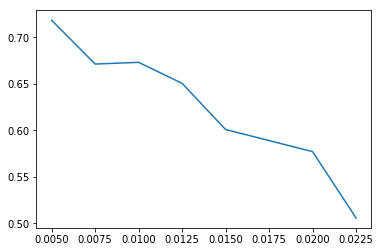

In [10]:
plt.plot(df_models['target_value'], df_models['precision'])
plt.show()

In [11]:
if df_models.empty:
    print('No Model worth fighting for... ')
possible_models = df_models.sort_values('target_value', ascending=False)

model = possible_models.iloc[0]
target_value = model['model']['Target']
stop_loss = model['stop_loss']
model = model['model']

In [12]:
risk_free = ((1 + 0.065) ** (1/252) - 1)

drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6'
               ]


back_test = df.copy()
mask = (
       ((back_test['log_return'] >= target_value)
        | (back_test['log_return_2'] >= target_value) 
        | (back_test['log_return_3'] >= target_value) 
        | (back_test['log_return_4'] >= target_value)
           ))
back_test.loc[mask, 'last_target'] = 1
back_test.loc[~mask, 'last_target'] = 0
for index, row in back_test.iloc[test_size:].iterrows():
    signal = 0
    current_date = row['date']
    X = row.drop(drop_columns)
    X = model['Scaler'].transform(X.ravel().reshape(1, -1))
    predicted_proba = model['Model'].predict_proba(X)
    if predicted_proba[0][1] >= threshold:
        signal = 1
    back_test.loc[back_test['date'] == row['date'], 'predicted_signal'] = signal

In [13]:
mask_profit = (
       ((back_test['target_log_return_1'] >= target_value)
        | (back_test['target_log_return_2'] >= target_value) 
        | (back_test['target_log_return_3'] >= target_value) 
        | (back_test['target_log_return_4'] >= target_value)
        | (back_test['target_log_return_5'] >= target_value)
        | (back_test['target_log_return_6'] >= target_value))
           )

mask_loss =  (
       ((back_test['target_log_return_1'] <= stop_loss)
        | (back_test['target_log_return_2'] <= stop_loss) 
        | (back_test['target_log_return_3'] <= stop_loss) 
        | (back_test['target_log_return_4'] <= stop_loss)
        | (back_test['target_log_return_5'] <= stop_loss)
        | (back_test['target_log_return_6'] <= stop_loss))
           )


back_test.loc[mask_profit & (~mask_loss), 'target_sign'] = 1
back_test.loc[mask_loss, 'target_sign'] = 0

In [14]:
for index, row in back_test.iterrows():
    hit = [row.target_log_return_1,
             row.target_log_return_2,
             row.target_log_return_3,
            row.target_log_return_4,
            row.target_log_return_5,
            row.target_log_return_6]
    hit = [j for j in hit if j <= stop_loss]
    if hit:
        back_test.loc[back_test.index == index, 'hit'] = max(hit)
    else:
        back_test.loc[back_test.index == index, 'hit'] = 0

In [15]:
results = back_test.dropna()
results.loc[(results['predicted_signal'] == 1) & (results['target_sign'] == 1), 'profit'] = target_value
results.loc[(results['predicted_signal'] == 1) & (results['target_sign'] == 0), 'profit'] = results.loc[(results['predicted_signal'] == 1) & (results['target_sign'] == 0), 'hit']
results.loc[(results['profit'].isnull()), 'profit'] = 0

/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/eduardo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
results['acc_return'] = results['profit'].cumsum().copy()

/home/eduardo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
print('All data to model from:')
print('------------------')
print('Starting data: ' + datetime.fromtimestamp(date_initial).strftime('%Y-%m-%d %H:%M:%S'))
print('------------------')
print('End data: ' + datetime.fromtimestamp(date_end).strftime('%Y-%m-%d %H:%M:%S'))
print('------------------')
print('Stop Loss: ' + str(stop_loss))
print('------------------')
print('Target Value: ' + str(target_value))
print('------------------')
print('Model Precision: ' + str(model['Precision']))
print('------------------')
print('Backtesting data :  ' + str((datetime.fromtimestamp(results.iloc[-1].date) - datetime.fromtimestamp(results.iloc[0].date)).days ))
print('------------------')
print('Starting data: ' + datetime.fromtimestamp(results.iloc[0].date).strftime('%Y-%m-%d %H:%M:%S'))
print('------------------')
print('End data: ' + datetime.fromtimestamp(results.iloc[-1].date).strftime('%Y-%m-%d %H:%M:%S'))
print('------------------')
print('Acc. Return Test: ' + str(results['acc_return'].iloc[-1]))
print('------------------')
print('Ratio Target/Loss: ' + str(abs(target_value/stop_loss)))

All data to model from:
------------------
Starting data: 2018-02-01 02:00:00
------------------
End data: 2018-10-03 09:00:00
------------------
Stop Loss: -0.051608985168
------------------
Target Value: 0.0225
------------------
Model Precision: 0.505882352941
------------------
Backtesting data :  4
------------------
Starting data: 2018-09-28 21:00:00
------------------
End data: 2018-10-03 01:00:00
------------------
Acc. Return Test: 0.045
------------------
Ratio Target/Loss: 0.435970595561


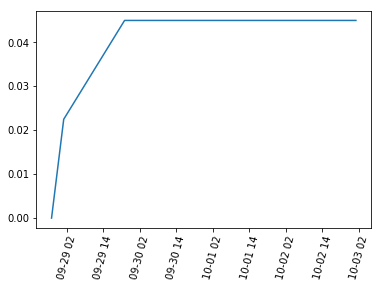

In [18]:
plt.plot(results.date.apply(lambda x: datetime.fromtimestamp(x)), results.acc_return)
plt.xticks(rotation=75)
plt.show()

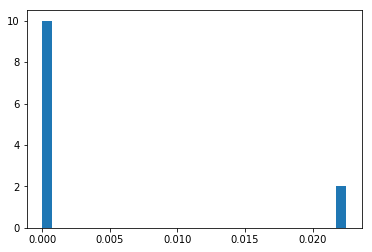

In [19]:
plt.hist(results['profit'], bins=30)
plt.show()

In [20]:
results[['predicted_signal', 'target_sign', 'profit', 'acc_return']]

,predicted_signal,target_sign,profit,acc_return
20042,0.0,1.0,0.0000,0.0000
20052,1.0,1.0,0.0225,0.0225
20104,1.0,1.0,0.0225,0.0450
20112,0.0,1.0,0.0000,0.0450
20208,0.0,0.0,0.0000,0.0450
20231,0.0,0.0,0.0000,0.0450
20238,0.0,0.0,0.0000,0.0450
20249,0.0,0.0,0.0000,0.0450
20258,0.0,0.0,0.0000,0.0450
20262,0.0,0.0,0.0000,0.0450


In [21]:
from sklearn.feature_selection import SelectFromModel

selection = SelectFromModel(model['Model'], threshold=0.03, prefit=True) 

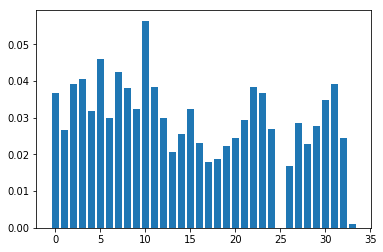

In [22]:
plt.bar(range(len(model['Model'].feature_importances_)), model['Model'].feature_importances_)
plt.show()

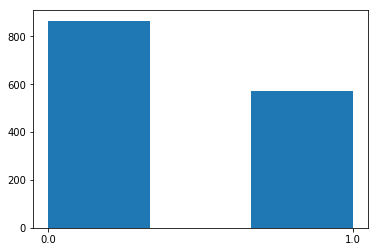

In [23]:
plt.hist(y, bins=3)
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

xgb_model = models['XGBoost']
    
back_test = df.copy().sort_values('date')
mask = (
       ((back_test['log_return'] >= target_value)
        | (back_test['log_return_2'] >= target_value) 
        | (back_test['log_return_3'] >= target_value) 
        | (back_test['log_return_4'] >= target_value)
           ))
back_test.loc[mask, 'last_target'] = 1
back_test.loc[~mask, 'last_target'] = 0
X, y, flat_missed_list, flat_list = get_x_y(target_value, back_test.iloc[:])
# X = selection.transform(X)
y_sample = y
X_sample = X
scaler = MinMaxScaler().fit(X_sample)
X_sample = scaler.transform(X_sample)
# Split Train, Test
X_train, X_test = X_sample[:math.floor(len(X_sample) * 0.75)], X_sample[math.ceil(len(X_sample) * 0.75):]
y_train, y_test = y_sample.iloc[:math.floor(len(y_sample) * 0.75)], y_sample.iloc[math.ceil(len(y_sample) * 0.75):]

# Rebalance Samples
oversampler = SMOTE(random_state=42)
X_train, y_train = oversampler.fit_sample(X_train, y_train.target_sign)

n_estimators = [100, 200, 300, 400, 500]
max_depth = [2, 4, 6, 8]
max_delta_step = [1, 2, 3, 4, 5]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,max_delta_step=max_delta_step)
kfold = StratifiedKFold(n_splits=2, shuffle=False, random_state=7)
grid_search = GridSearchCV(xgb_model, param_grid, scoring="precision", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

Setting up target variable...
Cleaning data set...
Getting list of returns...
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.3s finished


In [25]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.587397 using {'max_delta_step': 2, 'max_depth': 6, 'n_estimators': 500}


In [26]:
selected_model = xgb.XGBClassifier(max_depth=grid_result.best_params_['max_depth'],
                                 learning_rate=0.2, n_estimators=grid_result.best_params_['n_estimators'],
                                 objective= "binary:logistic", eval_metric="error", gamma=0.,  #map
                                 max_delta_step=grid_result.best_params_['max_delta_step'], subsample=0.9,
                                 colsample_bytree=0.4,
                    seed=0, )

selected_model.fit(X_train, y_train)

predicted_proba = selected_model.predict_proba(X_test)
predicted = (predicted_proba[:, 1] >= threshold).astype('int')
precision = precision_score(y_test, predicted)
train_acc = accuracy_score(y_test, predicted)

In [27]:
print("Best: %f precision, using target: %f and stop-loss: %f !!" % (precision, target_value, stop_loss))

Best: 0.503401 precision, using target: 0.022500 and stop-loss: -0.051609 !!


In [28]:
df_models

,model,precision,stop_loss,target_value
0,"{'Precision': 0.718309859155, 'Accuracy': 0.55...",0.718310,-0.064120,0.0050
1,"{'Precision': 0.671232876712, 'Accuracy': 0.55...",0.671233,-0.060682,0.0075
2,"{'Precision': 0.673076923077, 'Accuracy': 0.57...",0.673077,-0.059424,0.0100
3,"{'Precision': 0.650485436893, 'Accuracy': 0.56...",0.650485,-0.057179,0.0125
4,"{'Precision': 0.600896860987, 'Accuracy': 0.54...",0.600897,-0.055719,0.0150
5,"{'Precision': 0.577142857143, 'Accuracy': 0.55...",0.577143,-0.052787,0.0200
6,"{'Precision': 0.505882352941, 'Accuracy': 0.53...",0.505882,-0.051609,0.0225


In [29]:
model = {
    'take_profit': target_value,
    'stop_loss': stop_loss,
    'Scaler': X_sample,
    'Model': selected_model
    
}
filename = '../' + coin + '_model.sav'
pickle.dump(model, open(filename, 'wb'))